In [1]:
# imports and paths 

import os
import pickle
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

pd.set_option("display.width", 120)

PROJECT_ROOT = os.path.abspath("..")
DATA_PROCESSED = os.path.join(PROJECT_ROOT, "data", "processed")


In [2]:
# load covariance matrices 

with open(os.path.join(DATA_PROCESSED, "covariance_matrices.pkl"), "rb") as f:
    scenario_covs = pickle.load(f)

dates = list(scenario_covs.keys())
len(dates)


41

In [3]:
# Feature engineering 

features = []

for d in dates:
    cov = scenario_covs[d]["base"]
    
    vols = np.sqrt(np.diag(cov.values))
    avg_vol = np.mean(vols)
    vol_disp = np.std(vols)
    
    corr = cov.corr()
    upper = corr.values[np.triu_indices_from(corr, k=1)]
    avg_corr = np.mean(upper)
    corr_disp = np.std(upper)
    
    features.append({
        "date": d,
        "avg_vol": avg_vol,
        "vol_disp": vol_disp,
        "avg_corr": avg_corr,
        "corr_disp": corr_disp
    })

feature_df = pd.DataFrame(features).set_index("date")
feature_df.head()


,avg_vol,vol_disp,avg_corr,corr_disp
date,,,,
2021-04-30,0.016799,0.007217,0.050169,0.589394
2021-06-30,0.013091,0.004905,0.077216,0.524905
2021-08-31,0.012180,0.003905,0.044237,0.454135
2021-09-30,0.012754,0.003876,0.074142,0.439245
2021-11-30,0.015314,0.005968,0.122046,0.390096


In [4]:
# Normalize features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(feature_df.values)

X_scaled.shape



(41, 4)

In [5]:
# Train KMeans model (Unsupervised Learning) )

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

feature_df["cluster"] = clusters
feature_df.head()


,avg_vol,vol_disp,avg_corr,corr_disp,cluster
date,,,,,
2021-04-30,0.016799,0.007217,0.050169,0.589394,1
2021-06-30,0.013091,0.004905,0.077216,0.524905,1
2021-08-31,0.012180,0.003905,0.044237,0.454135,1
2021-09-30,0.012754,0.003876,0.074142,0.439245,1
2021-11-30,0.015314,0.005968,0.122046,0.390096,1


In [6]:
# Map clusters -> regime names 

cluster_vol = feature_df.groupby("cluster")["avg_vol"].mean().sort_values()
cluster_vol


cluster
1    0.015262
2    0.022100
0    0.022874
Name: avg_vol, dtype: float64

In [7]:
regime_map = {
    cluster_vol.index[0]: "low_vol",
    cluster_vol.index[1]: "mid_vol",
    cluster_vol.index[2]: "high_vol"
}

feature_df["regime"] = feature_df["cluster"].map(regime_map)
feature_df.head()


,avg_vol,vol_disp,avg_corr,corr_disp,cluster,regime
date,,,,,,
2021-04-30,0.016799,0.007217,0.050169,0.589394,1,low_vol
2021-06-30,0.013091,0.004905,0.077216,0.524905,1,low_vol
2021-08-31,0.012180,0.003905,0.044237,0.454135,1,low_vol
2021-09-30,0.012754,0.003876,0.074142,0.439245,1,low_vol
2021-11-30,0.015314,0.005968,0.122046,0.390096,1,low_vol


In [8]:
# sanity check 

feature_df["regime"].value_counts()


regime
low_vol     26
mid_vol      9
high_vol     6
Name: count, dtype: int64

In [9]:
# save regime labels 

feature_df[["regime"]].to_csv(
    os.path.join(DATA_PROCESSED, "market_regimes.csv")
)

"market_regimes.csv saved"


'market_regimes.csv saved'

In [10]:
# Regime access api 

def get_market_regime(date):
    return feature_df.loc[date, "regime"]


In [11]:
# Qucik test 

sample_date = feature_df.index[5]
sample_date, get_market_regime(sample_date)


(Timestamp('2021-12-31 00:00:00'), 'low_vol')

<Axes: title={'center': 'Average Volatility with ML Regimes'}, xlabel='date'>

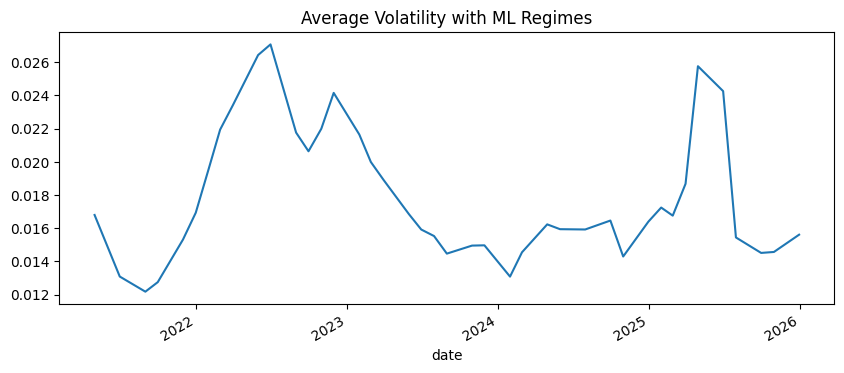

In [12]:
feature_df["avg_vol"].plot(
    title="Average Volatility with ML Regimes",
    figsize=(10,4)
)


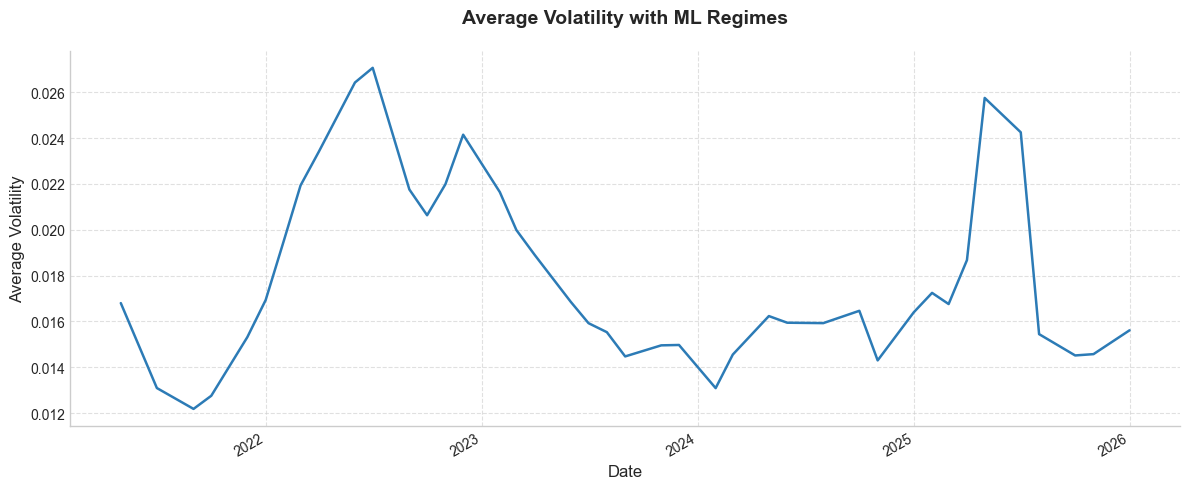

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean, modern style
plt.style.use('seaborn-v0_8-whitegrid')  # or 'ggplot', 'seaborn-darkgrid', etc.
sns.set_palette("tab10")

# Create the plot
fig, ax = plt.subplots(figsize=(12, 5))

feature_df["avg_vol"].plot(
    ax=ax,
    color='#2C7BB6',
    linewidth=1.8,
    title="Average Volatility with ML Regimes"
)

# Improve aesthetics
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Average Volatility", fontsize=12)
ax.set_title("Average Volatility with ML Regimes", fontsize=14, fontweight='bold', pad=20)
ax.grid(True, linestyle='--', alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Optional: Tighten layout
plt.tight_layout()
plt.show()